In [1]:
import numpy as np
import ggseg
import pickle

from matplotlib import pyplot as plt 
import pandas as pd 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
import plotly.offline as pyo

import json

### NEW FILE

In [2]:
read_input_file = open('data/EDADS_subtype_timelines_agecorrected_opt.pickle','rb')
load_inputs = pickle.load(read_input_file)
read_input_file.close()

T, S, Sboot = load_inputs

/Users/macos/opt/anaconda3/envs/umc/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator MinCovDet from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations



### OLD FILE

In [22]:
read_input_file = open('/Users/macos/Documents/GitHub/Master_Thesis/data/ADC_FTLD_subtypes_agecorrected_zscore_final.pickle','rb')
load_inputs = pickle.load(read_input_file)
read_input_file.close()

T_old, S_old, Sboot_old = load_inputs

# Separate Subcortical & Cortical Regions

### Load mappings

In [4]:
f = open('data/DK_2D_combined.json')
DK_2D_combined = json.load(f)
f.close()

f = open('data/DK_2D_separated.json')
DK_2D_separated = json.load(f)
f.close()

f = open('data/ASEG_combined.json')
ASEG_2D_combined = json.load(f)
f.close()

f = open('data/ASEG_separated.json')
ASEG_2D_separated = json.load(f)
f.close()

### Map DK

Map values from larger regions to each small region included

In [5]:
def dk_dict(T,S, mapped_dict, subtype_labels = None, subtype = None):
    
    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() function
    :param T: dataframe from dk_dataframe() function
    :param S: chosen subtype
    :param mapped_dict: a dictionary with key: values --> T.biomarker_labels: list(DK-labels)
    :param subtype: name or index of the subtype from subtype_lables (optional, choses first available subtype as default)  
    :param subtype_labels: a list with names of the subtypes (optional)
    :return: dictionary with scores for each DK region for chosen subtype
    """
    
    unique_subtypes = np.unique(S['subtypes'][~np.isnan(S['subtypes'])])
    if subtype_labels is None:
        subtype_labels = {f'Subtype {i}': i for i in range(len(unique_subtypes))}
        if subtype is None:
            subtype = next(iter(subtype_labels))
    elif subtype is None:
        subtype = subtype_labels[0]  
        
        
    # clean names from capital letters
    labels = list(map(lambda x: x.lower(), T.biomarker_labels))
    labels_dict = {num: label.lower() for num, label in enumerate(labels)}
    
    order = T.sequence_model['ordering'][subtype_labels[subtype]]
    
    labels_ordered = []
    for o in order:
        labels_ordered.append(labels_dict[o])   
    
    # All regions
    dic = dict(zip(labels_ordered, T.sequence_model['event_centers'][subtype_labels[subtype]]))
                    
    # flat list of dict values (single list of DK-labels)
    dk_flat = [x for v in mapped_dict.values() for x in v]
                
    #Match T.biomarker_labels to DK labels
    list_plot = list()
    for key in mapped_dict.keys():
            for item in mapped_dict[key]:
                list_plot.append(dic[key])
                    
    # Dict for dk-label: T.label value
    dic_dk = dict(zip(dk_flat, list_plot))
    
    return dic_dk

In [6]:
def aseg_dict(T, S, mapped_dict, subtype_labels = None, subtype = None, hemi = False):
    
    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() function
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param mapped_dict: a dictionary with key: values --> T.biomarker_labels: list(DK-labels)
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype from subtype_lables (optional, choses first available subtype as default)  
    :return: dictionary with scores for each DK region for chosen subtype
    """

    unique_subtypes = np.unique(S['subtypes'][~np.isnan(S['subtypes'])])
    if subtype_labels is None:
        subtype_labels = {f'Subtype {i}': i for i in range(len(unique_subtypes))}
        if subtype is None:
            subtype = next(iter(subtype_labels))
    elif subtype is None:
        subtype = subtype_labels[0]
    
    # clean names from capital letters
    labels = T.biomarker_labels
    labels_dict = {num: label.lower() for num, label in enumerate(labels)}
    order = T.sequence_model['ordering'][subtype_labels[subtype]]
    
    labels_ordered = []
    for o in order:
        labels_ordered.append(labels_dict[o])    
     
    # Dictionary with all labels
    dic = dict(zip(labels_ordered, T.sequence_model['event_centers'][subtype_labels[subtype]]))
    
    # flat list of dict values (single list of DK-labels)
    aseg_flat = [x for v in mapped_dict.values() for x in v]
            
    #Match T.biomarker_labels to DK labels
    list_plot = list()
    for key in mapped_dict.keys():
        for item in mapped_dict[key]:
            list_plot.append(dic[key])
            
    # Dict for dk-label: T.label value
    dic_aseg = dict(zip(aseg_flat, list_plot))    
        
    return dic_aseg

### Combined function rerturning both plots

In [7]:
def plot_ggseg(T,S, map_dk, map_aseg, subtype_labels = None, subtype = None): 
    
    import ggseg
    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() function
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param mapped_dict: a dictionary with key: values --> T.biomarker_labels: list(DK-labels)
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype from subtype_lables (optional, choses first available subtype as default)  
    :return: two plots -> ggseg.plot_dk() and ggseg.plot_aseg()
    """
    
    dk = dk_dict(T, S, mapped_dict = map_dk, subtype = subtype)
    
    aseg = aseg_dict(T,S, mapped_dict = map_aseg, subtype = subtype)
    
    if subtype is None:
        subtype = 'default = 0'

    
    ggseg.plot_dk(dk, cmap='Reds_r', figsize=(10,10),
              vminmax = [0,1],
              background='k', edgecolor='w', bordercolor='gray', title=f'Subtype: {subtype}',
                fontsize = 24)

    ggseg.plot_aseg(aseg, cmap='Reds_r', figsize=(10,10),
                vminmax = [0,1],
                background='k', edgecolor='w', bordercolor='gray', title=f'Subcortical regions for Subtype: {subtype}',
                fontsize = 24)

## Separate plots - for Streamlit App, with Slider

In [13]:
def plot_dk_atlas(T,S, map_dk, subtype_labels = None, subtype = None, slider = None):     

    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() and plots it
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype to visualise (optional)  
    :param slider: int (optional)
    :returns a figures by plt.show() -> ggseg.plot_dk() 
    """   
    
    if slider is None:
        dk = dk_dict(T, S, mapped_dict = map_dk, subtype = subtype)  
    else:
        dk_ = dk_dict(T, S, mapped_dict = map_dk, subtype = subtype)
        dk = {k: v for k, v in dk_.items() if v <= slider}
        
    
    if subtype is None:
        # subtype = 'default = 0'
        pass
    else:
        return ggseg.plot_dk(dk, cmap='Reds_r', figsize=(6,6),
                  vminmax = [0,1],
                  background='black', edgecolor='white', bordercolor='gray', title=f'{subtype}',fontsize = 24)


def plot_aseg_atlas(T,S, map_aseg, subtype_labels = None, subtype = None, slider = None):     

    """
    Creates a dictionary, which can be used as input to ggseg.plot_aseg() function
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype to visualise (optional)  
    :param slider: int (optional)
    :returns a figures by plt.show() -> ggseg.plot_aseg()
    """
    if slider is None:  
        aseg = aseg_dict(T,S, map_aseg,subtype = subtype)
    else:
        aseg_ = aseg_dict(T,S, map_aseg, subtype = subtype)
        aseg = {k: v for k, v in aseg_.items() if v <= slider}

    if subtype is None:
        # subtype = 'Subtype 0'
        pass 
    else:
        return ggseg.plot_aseg(aseg, cmap='Reds_r', figsize=(6,6),
                vminmax = [0,1],
                background='black', edgecolor='white', bordercolor='gray', title=f'{subtype}', fontsize = 18)

## NEW FILE

In [9]:
# 1. Map to DK-labels
dk_0_new = dk_dict(T, S, mapped_dict = DK_2D_combined, subtype='Subtype 0')
dk_0_new

{'bankssts_left': 0.06045564202282132,
 'transversetemporal_left': 0.06045564202282132,
 'superiortemporal_left': 0.06045564202282132,
 'temporalpole_left': 0.06045564202282132,
 'entorhinal_left': 0.06045564202282132,
 'middletemporal_left': 0.06045564202282132,
 'inferiortemporal_left': 0.06045564202282132,
 'fusiform_left': 0.06045564202282132,
 'bankssts_right': 0.06045564202282132,
 'transversetemporal_right': 0.06045564202282132,
 'superiortemporal_right': 0.06045564202282132,
 'temporalpole_right': 0.06045564202282132,
 'entorhinal_right': 0.06045564202282132,
 'middletemporal_right': 0.06045564202282132,
 'inferiortemporal_right': 0.06045564202282132,
 'fusiform_right': 0.06045564202282132,
 'superiorfrontal_left': 0.8244437592573389,
 'frontalpole_left': 0.8244437592573389,
 'superiorfrontal_right': 0.8244437592573389,
 'frontalpole_right': 0.8244437592573389,
 'caudalmiddlefrontal_left': 0.788296443542571,
 'rostralmiddlefrontal_left': 0.788296443542571,
 'caudalmiddlefrontal

In [10]:
# 2. Map to ASEG-labels
aseg_0_new = aseg_dict(T,S, mapped_dict = ASEG_2D_combined,subtype='Subtype 0')
aseg_0_new

{'Right-Thalamus': 0.26470706476375555,
 'Left-Thalamus': 0.26470706476375555,
 'Right-Caudate': 0.22816370825980395,
 'Left-Caudate': 0.22816370825980395,
 'Right-Putamen': 0.18590739892784688,
 'Left-Putamen': 0.18590739892784688,
 'Right-Hippocampus': 0.11026021836092065,
 'Left-Hippocampus': 0.11026021836092065,
 'Right-Amygdala': 0.8244437592573389,
 'Left-Amygdala': 0.8244437592573389}

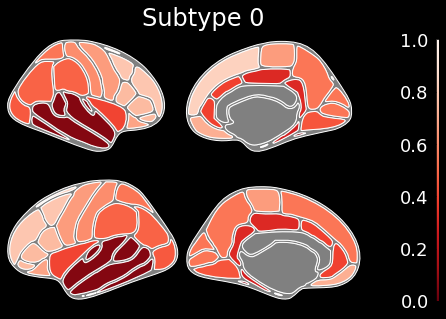

In [14]:
# 3. Plot DK
plot_dk_atlas(T = T, S = S, map_dk = DK_2D_combined, subtype = 'Subtype 0')  

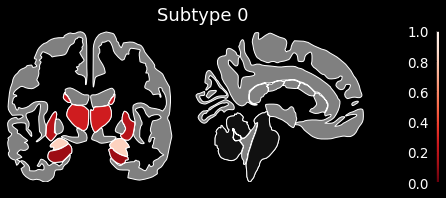

In [15]:
# 4. Plot ASEG
plot_aseg_atlas(T = T, S = S, map_aseg = ASEG_2D_combined, subtype = 'Subtype 0')  

In [18]:
# 5. Plot together
# plot_ggseg(T, S, DK_2D_combined, ASEG_2D_combined, subtype_labels = None, subtype = 'Subtype 0')

## OLD FILE

In [23]:
# 1. Map to DK-labels
dk_0_old = dk_dict(T_old, S_old, mapped_dict = DK_2D_separated)
# dk_0_old

In [24]:
# 2. Map to ASEG-labels
aseg_0_old = aseg_dict(T_old,S_old, mapped_dict = ASEG_2D_separated,subtype='Subtype 0')
# aseg_0_old

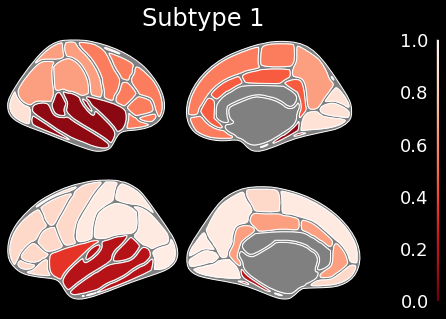

In [25]:
# 3. Plot DK
plot_dk_atlas(T = T_old, S = S_old, map_dk = DK_2D_separated, subtype = 'Subtype 1')  

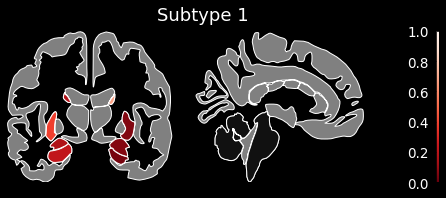

In [26]:
# 4. Plot ASEG
plot_aseg_atlas(T = T_old, S = S_old, map_aseg = ASEG_2D_separated, subtype = 'Subtype 1')  

In [28]:
# 5. Plot together
# plot_ggseg(T_old, S_old, DK_2D_separated, ASEG_2D_separated, subtype = 'Subtype 1')